In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import urllib.request
import math
import seaborn as sns

import argparse

from io import StringIO
from scipy.io import arff
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from torch.utils.data import TensorDataset, DataLoader
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import MinMaxScaler
from sklearn import svm

In [ ]:
ftpstream = urllib.request.urlopen('http://www.ece.uah.edu/~thm0009/icsdatasets/IanArffDataset.arff')
arffdata, arffmeta = arff.loadarff(StringIO(ftpstream.read().decode('utf-8')))

data_df = pd.DataFrame(arffdata)
data_df = data_df[data_df["time"]

data_df['command response'] = data_df['command response'].str.decode("utf-8")
data_df['binary result'] = data_df['binary result'].str.decode("utf-8")
data_df['categorized result'] = data_df['categorized result'].str.decode("utf-8")
data_df['specific result'] = data_df['specific result'].str.decode("utf-8")

data_df['command response'] = data_df['command response'].astype(float)
data_df['binary result']  = data_df['binary result'] .astype(float)
data_df['categorized result'] = data_df['categorized result'].astype(float)
data_df['specific result'] = data_df['specific result'].astype(float)

data_df['nc'] = data_df.isnull().sum(axis=1)
data_df = data_df.sort_values('time')

nancols = data_df.columns[data_df.isna().any()].tolist()
for col in nancols:
  data_df[col] = data_df[col].interpolate()

not_numbers = data_df.isin([np.inf, -np.inf]).sum().sum() + data_df.isna().sum().sum()

data_df = data_df.dropna()
not_numbers = data_df.isin([np.inf, -np.inf]).sum().sum() + data_df.isna().sum().sum()

print(data_df.shape)

In [ ]:
datacols = ['address', 'function', 'length', 'setpoint', 'gain', 'reset rate',
            'deadband', 'cycle time', 'rate', 'system mode', 'control scheme', 'pump',
            'solenoid', 'pressure measurement', 'crc rate']
additional_cols = ['specific result', 'categorized result', 'binary result', 'time', 'command response', 'nc']

#skalowanie
scaler = MinMaxScaler()
scaler.fit(data_df[datacols])
data_df[datacols] = pd.DataFrame(scaler.transform(data_df[datacols]))

attack_df = data_df[data_df['binary result'] == 1]
normal_df = data_df[data_df['binary result'] == 0]

In [ ]:
input_size = 14
input_size1 = 14

encoding_dim = 9
encoding_dim2 = 9
cons_frames = 9

parser = argparse.ArgumentParser()
args = parser.parse_args('')

args.batch_size = 1
args.n_layers = 1
args.embedding_dim = 64
args.dropout = 0
args.use_bn = False

In [ ]:
train_normal_df, test_normal_df = train_test_split(normal_df, test_size=0.3, shuffle=False)

train_all_df, test_all_df = train_test_split(data_df, test_size=0.3, shuffle=False)

train_df1 = train_normal_df
train_df1 = train_df1.dropna(axis=1, how='all')
train_additional_df1 = train_df1['binary result']
train_df1 = train_df1.drop(columns=additional_cols)
train_data1 = torch.tensor(train_df1.values, dtype=torch.float32)
train_additional_data1 = torch.tensor(train_additional_df1.values, dtype=torch.float32)
train_dataset1 = TensorDataset(train_data1, train_additional_data1)
loader_train_1 = DataLoader(train_dataset1, batch_size=cons_frames, shuffle=False, drop_last=True)

test_df1 = test_normal_df
test_df1 = test_df1.dropna(axis=1, how='all')
test_additional_df1 = test_df1['binary result']
test_df1 = test_df1.drop(columns=additional_cols)
test_data1 = torch.tensor(test_df1.values, dtype=torch.float32)
test_additional_data1 = torch.tensor(test_additional_df1.values, dtype=torch.float32)
test_dataset1 = TensorDataset(test_data1, test_additional_data1)
loader_test_1 = DataLoader(test_dataset1, batch_size=cons_frames, shuffle=False, drop_last=True)

test_a_df1 = test_all_df
test_a_df1 = test_a_df1.dropna(axis=1, how='all')
test_a_df1 = test_a_df1.dropna()
test_additional_a_df1 = test_a_df1['binary result']
test_a_df1 = test_a_df1.drop(columns=additional_cols)
test_a_data1 = torch.tensor(test_a_df1.values, dtype=torch.float32)
test_additional_a_data1 = torch.tensor(test_additional_a_df1.values, dtype=torch.float32)
test_a_dataset1 = TensorDataset(test_a_data1, test_additional_a_data1)
loader_test_a_1 = DataLoader(test_a_dataset1, batch_size=cons_frames, shuffle=False, drop_last=True)

train_a_df1 = train_all_df
train_a_df1 = train_a_df1.dropna(axis=1, how='all')
train_a_df1 = train_a_df1.dropna()
train_additional_a_df1 = train_a_df1['binary result']
train_a_df1 = train_a_df1.drop(columns=additional_cols)
train_a_data1 = torch.tensor(train_a_df1.values, dtype=torch.float32)
train_additional_a_data1 = torch.tensor(train_additional_a_df1.values, dtype=torch.float32)
train_a_dataset1 = TensorDataset(train_a_data1, train_additional_a_data1)
loader_train_a_1 = DataLoader(train_a_dataset1, batch_size=cons_frames, shuffle=False, drop_last=True)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super().__init__()

        self.hidden_dim = 2 * args.embedding_dim
        self.seq_len = encoding_dim
        self.n_features = input_size

        self.rnn1 = nn.LSTM(
            input_size=input_size,
            hidden_size=self.hidden_dim,
            num_layers=args.n_layers,
            batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=args.embedding_dim,
            num_layers=args.n_layers,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((args.batch_size, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((1, args.embedding_dim))

class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_size):
        super().__init__()
        self.seq_len = encoding_dim
        self.hidden_dim = 2 * args.embedding_dim
        self.n_features = input_size

        self.rnn1 = nn.LSTM(
            input_size=args.embedding_dim,
            hidden_size=args.embedding_dim,
            num_layers=args.n_layers,
            batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=args.embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=args.n_layers,
            batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, input_size)

    def forward(self, x):
        x = x.repeat(self.seq_len, args.batch_size)
        x = x.reshape((1, self.seq_len, args.embedding_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super().__init__()
        self.encoder = Encoder(input_size, encoding_dim)
        self.decoder = Decoder(encoding_dim, input_size)
        self.hidden_n = []

    def forward(self, x):
        x = x.unsqueeze(0)
        x = self.encoder(x)
        self.hidden_n = x;
        x = self.decoder(x)
        return x

    def encoded(self):
        return self.hidden_n

autoencoder1 = Autoencoder(15, encoding_dim)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train(model, trainloader=None, valloader=None, num_epochs=10):
    losses = []

    phases = ['train']
    print(phases)
    dataloaders = {'train':trainloader}
    if valloader:
        phases.append('valid')
        dataloaders['valid'] = valloader

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.MSELoss()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}\n{"-"*10}')

        for phase in phases:
            if phase == 'train':
                model.train()
            else: model.eval()

            running_loss, running_correct, count = 0.0, 0, 0

            for i, minibatch in enumerate(dataloaders[phase]):
                values, _ = minibatch
                values = values.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(values)
                    loss    = criterion(outputs, values)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * values.size(0)
                count += len(values)

                losses.append(loss.item())

            epoch_loss = running_loss / count
            print(f'{phase} loss {epoch_loss:.6f}')
        print()
    return losses

In [ ]:
loss_hist1 = train(autoencoder1, loader_train_1, loader_test_1, 12)

['train']
Epoch 1/12
----------
train loss 0.042801
valid loss 0.107331

Epoch 2/12
----------
train loss 0.046445
valid loss 0.113937

Epoch 3/12
----------
train loss 0.046428
valid loss 0.097810

Epoch 4/12
----------
train loss 0.044481
valid loss 0.110805

Epoch 5/12
----------
train loss 0.046664
valid loss 0.085452

Epoch 6/12
----------
train loss 0.045748
valid loss 0.116348

Epoch 7/12
----------
train loss 0.047160
valid loss 0.109860

Epoch 8/12
----------
train loss 0.044180
valid loss 0.097053

Epoch 9/12
----------
train loss 0.044670
valid loss 0.086256

Epoch 10/12
----------
train loss 0.042703
valid loss 0.076924

Epoch 11/12
----------
train loss 0.039152
valid loss 0.074502

Epoch 12/12
----------
train loss 0.035701
valid loss 0.068658



In [ ]:
print(train_a_data1.shape)
a1, a2 = train_test_split(train_a_data1, test_size=0.2, shuffle=False)
b1, b2 = train_test_split(train_additional_a_data1, test_size=0.2, shuffle=False)
print(a1.shape)

td1 = TensorDataset(a1, b1)
ldt1 = DataLoader(td1, batch_size=cons_frames, shuffle=False, drop_last=True)

torch.Size([30441, 15])
torch.Size([24352, 15])


In [ ]:
outputs_train = []
for i, minibatch in enumerate(loader_train_a_1):
    values, _ = minibatch
    values = values.to(device)
    output = autoencoder1(values)
    outputs_train.append(output)

results = torch.cat(outputs_train, dim=0)

diff_train = train_a_data1 - results

diff_train = diff_train.detach().numpy()
print(diff_train.shape)

In [ ]:
#print(train_additional_a_data1.shape)
#train_additional_a_data1 = torch.cat((train_additional_a_data1[:9804],train_additional_a_data1[9814:]))
#print(train_additional_a_data1.shape)

#clf = OneClassSVM(nu=0.08, kernel="rbf", gamma=0.3)
clf = svm.SVC(kernel='rbf')
#clf = MLPClassifier(alpha=1e-7,hidden_layer_sizes=(8, 4),max_iter=1000)

#clf.fit(diff_train,train_additional_a_data1)
clf.fit(diff_train,torch.cat((train_additional_a_data1[:68310],train_additional_a_data1[68318:])))
#clf.fit(diff_train)

SVC()

In [ ]:
outputs = []
for i, minibatch in enumerate(loader_test_a_1):
    values, _ = minibatch
    values = values.to(device)
    output = autoencoder1(values)
    outputs.append(output)

results = torch.cat(outputs, dim=0)

print(results)
test_a_data1 = torch.cat((test_a_data1[:29277],test_a_data1[29278:]))
diff = test_a_data1 - results

display(diff)

diff = diff.detach().numpy()

predictions_test = clf.predict(diff)

#predictions_test[predictions_test == 1]=0
#predictions_test[predictions_test == -1]=1

print(predictions_test)
print(predictions_test.tolist().count(1))
print(predictions_test.tolist().count(0))

tensor([[0.2108, 0.1135, 0.3767,  ..., 0.0149, 0.0057, 0.2272],
        [0.2104, 0.1114, 0.3806,  ..., 0.0592, 0.0032, 0.2278],
        [0.2103, 0.1109, 0.3814,  ..., 0.0671, 0.0026, 0.2281],
        ...,
        [0.2075, 0.0671, 0.4151,  ..., 1.0225, 0.0029, 0.2205],
        [0.2075, 0.0669, 0.4150,  ..., 1.0219, 0.0030, 0.2205],
        [0.2075, 0.0668, 0.4150,  ..., 1.0215, 0.0031, 0.2205]],
       grad_fn=<CatBackward0>)


tensor([[-2.8628e-04, -9.5944e-02,  7.3299e-02,  ..., -1.4919e-02,
         -5.6847e-03, -3.4076e-03],
        [ 1.1401e-04, -1.7837e-02,  6.1935e-01,  ..., -5.9231e-02,
         -3.1531e-03,  2.7569e-02],
        [ 1.9816e-04, -1.7359e-02, -3.0644e-01,  ..., -6.7056e-02,
         -2.6319e-03,  4.2828e-02],
        ...,
        [ 3.0124e-03,  2.6491e-02,  5.8495e-01,  ..., -2.2482e-02,
         -2.9141e-03, -2.3869e-02],
        [ 3.0248e-03,  2.6630e-02, -3.4004e-01,  ..., -2.1854e-02,
         -3.0330e-03,  5.0401e-02],
        [ 3.0331e-03, -4.9265e-02, -3.4004e-01,  ..., -2.1460e-02,
         -3.1325e-03, -2.3837e-02]], grad_fn=<SubBackward0>)

[0. 0. 0. ... 0. 0. 0.]
3275
26002


0.8097824230624723
0.7187786259541985
0.3361896600971151
0.45811034348545293


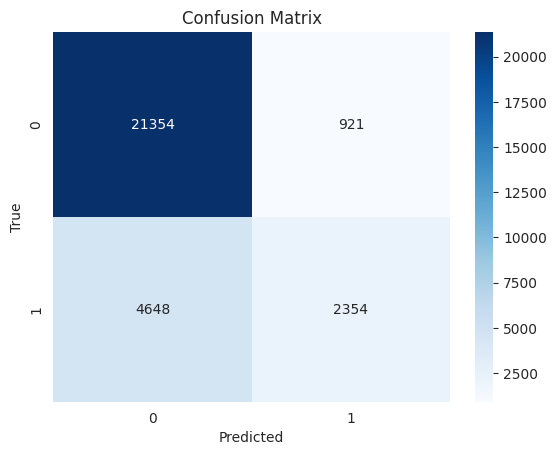

In [ ]:
v1 = test_additional_a_df1.values.tolist()
v2 = predictions_test.tolist()

cm = confusion_matrix(v1,v2)

accuracy = accuracy_score(v1,v2)
precision = precision_score(v1,v2)
recall = recall_score(v1,v2)
f1 = f1_score(v1,v2)

print(accuracy)
print(precision)
print(recall)
print(f1)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
tick_labels = ['0', '1']
plt.xticks(np.arange(2) + 0.5, tick_labels)
plt.yticks(np.arange(2) + 0.5, tick_labels)
plt.show()